In [1]:

import os

import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt

from storage import upload_to_bucket

from schema import Schema, ShoeboxGeometryParameter, BuildingTemplateParameter, WhiteboxSimulation, WindowParameter, SchedulesParameters
from nrel_uitls import ResStockConfiguration


In [2]:
schema = Schema()

In [3]:

basepath = os.path.dirname(os.getcwd())
filepath = os.path.join(basepath, "NREL", "data", "ResStock", "resstock_filtered.csv")
citypath = os.path.join(os.getcwd(), "data", "city_map.json")
resstock_filtered = pd.read_csv(filepath, index_col=0)
resstock_samples = ResStockConfiguration(resstock_filtered, citypath)
sample_df = resstock_samples.get_template_df()
sample_df.head()
sample_df.RoofRValue.describe()


Dropped 17 samples while cleaning. Now there are 591 samples.


count    591.000000
mean       0.945962
std        1.832182
min        0.037500
25%        0.272143
50%        0.272143
75%        0.272143
max        8.901942
Name: RoofRValue, dtype: float64

In [4]:
sample_df.columns, schema.parameter_names

(Index(['bldg_id', 'archetype', 'vintage', 'climate_zone', 'base_epw',
        'window_type', 'wwr', 'heating_setpoint', 'cooling_setpoint',
        'Infiltration', 'dhw_flow', 'PeopleDensity', 'LightingPowerDensity',
        'EquipmentPowerDensity', 'FacadeMass', 'FacadeRValue', 'RoofRValue',
        'PartitionRValue', 'SlabRValue', 'has_electric_heating', 'heating_cop',
        'has_cooling', 'cooling_cop'],
       dtype='object'),
 ['batch_id',
  'variation_id',
  'program_type',
  'vintage',
  'climate_zone',
  'base_epw',
  'width',
  'height',
  'facade_2_footprint',
  'perim_2_footprint',
  'roof_2_footprint',
  'footprint_2_ground',
  'wwr',
  'orientation',
  'HeatingSetpoint',
  'CoolingSetpoint',
  'LightingPowerDensity',
  'EquipmentPowerDensity',
  'PeopleDensity',
  'Infiltration',
  'FacadeMass',
  'RoofMass',
  'FacadeRValue',
  'RoofRValue',
  'SlabRValue',
  'WindowSettings',
  'schedules_seed',
  'schedules'])

In [5]:
start_ix = 0
batches_to_gen = 591
batches = []
for batch_id in range(start_ix, start_ix+batches_to_gen):
    base = sample_df.iloc[batch_id]
    storage_batch = schema.generate_empty_storage_batch(1)
    print(base.base_epw)
    print(base.RoofRValue)
    print(base.FacadeMass)
    
    # Set Constants
    schema.update_storage_batch(storage_batch,parameter="batch_id",value=batch_id)
    schema.update_storage_batch(storage_batch,parameter="base_epw",value=base.base_epw)
    schema.update_storage_batch(storage_batch,parameter="climate_zone",value=base.climate_zone)
    schema.update_storage_batch(storage_batch,parameter="program_type",value=base.archetype)
    schema.update_storage_batch(storage_batch,parameter="vintage",value=base.vintage)
    
    # Set Defaults
    schema.update_storage_batch(storage_batch, parameter="wwr", value=base.wwr)
    schema.update_storage_batch(storage_batch, parameter="HeatingSetpoint", value=base.heating_setpoint)
    schema.update_storage_batch(storage_batch, parameter="CoolingSetpoint", value=base.cooling_setpoint)
    schema.update_storage_batch(storage_batch, parameter="Infiltration", value=base.Infiltration)
    schema.update_storage_batch(storage_batch, parameter="EquipmentPowerDensity", value=base.EquipmentPowerDensity)
    schema.update_storage_batch(storage_batch, parameter="LightingPowerDensity", value=base.LightingPowerDensity)
    schema.update_storage_batch(storage_batch, parameter="PeopleDensity", value=base.PeopleDensity)
    schema.update_storage_batch(storage_batch, parameter="FacadeMass", value=base.FacadeMass)
    schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=base.FacadeRValue)
    schema.update_storage_batch(storage_batch, parameter="RoofRValue", value=base.RoofRValue)
    schema.update_storage_batch(storage_batch, parameter="SlabRValue", value=base.SlabRValue)

    schema.update_storage_batch(storage_batch, parameter="WindowSettings", value=np.array([0.7,0.5,0.7])) 

    # TODO: roofmass
    # TODO: windows
    # TODO: add summed output of product of schedules with loads
    # TODO: Internal mass?

    # Generate Orientations
    storage_batch = storage_batch.repeat(4,axis=0)
    orientations = np.arange(4).reshape(-1,1)
    schema.update_storage_batch(storage_batch, parameter="orientation", value=orientations)

    # geneate geometric variations
    geo_var_ct = 5
    storage_batch = storage_batch.repeat(geo_var_ct,axis=0)
    for j,parameter in enumerate(schema.parameters):
        if isinstance(parameter, ShoeboxGeometryParameter):
            name = parameter.name
            mean = parameter.mean
            std = parameter.std
            shape = parameter.shape_storage
            values = np.random.normal(loc=mean, scale=std, size=(storage_batch.shape[0], *shape))
            schema.update_storage_batch(storage_batch, parameter=name, value=values)
    
    """Generate Schedules"""
    sched_var_ct = 10
    storage_batch = storage_batch.repeat(sched_var_ct, axis=0)
    for minibatch_ix in range(0,storage_batch.shape[0],sched_var_ct):
        vec_base_ix = minibatch_ix
        for sched_ix in range(sched_var_ct):
            vec_ix = vec_base_ix + sched_ix
            schedules = schema["schedules"].extract_storage_values(storage_batch[vec_ix])
            if sched_ix == 0:
                # use default sched
                pass
            elif sched_ix == 1:
                # all on
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["on/off"]] = 1
            elif sched_ix == 2:
                # all off
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["on/off"]] = -1
            elif sched_ix == 3:
                # Daily random
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # 1hr per sample
                    schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24 # 1 days worth of samples
                    schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
            elif sched_ix == 4:
                # Daily random
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 1 # 1hr per sample
                    schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24*7 # 1 week worth of samples
                    schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 2
            elif sched_ix == 5:
                # Daily rando
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = (j+1)*2 # 1hr per sample
                    schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24/(j+1)*2*7 # 1 week worth of samples
                    schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 2
            # elif sched_ix == 4:
            #     # Weekly random
            #     for j in range(3):
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 4 # 4hr per sample
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24/4*7 # 1 week worth of samples
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
            # elif sched_ix == 5:
            #     # Weekly random
            #     for j in range(3):
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 2 # 2hr per sample
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 24/2*7 # 2 worth of samples
            #         schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
            elif sched_ix == 6:
                # Inverted
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["invert"]] = 1
            elif sched_ix == 7:
                # Noise
                for j in range(3):
                    # schedules[j, SchedulesParameters.op_indices["noise"]] = 0.2
                    schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 24 # 1day per sample
                    schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 7 # 1 week worth of samples
                    schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
            elif sched_ix == 8:
                # work week
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["pulse_period"]] = 24*7 # 1 week
                    schedules[j, SchedulesParameters.op_indices["pulse_width"]] = 24*5 # 5 days
            elif sched_ix == 9:
                # phasing
                for j in range(3):
                    schedules[j, SchedulesParameters.op_indices["pulse_period"]] = 12 # 1 week
                    schedules[j, SchedulesParameters.op_indices["pulse_width"]] = 4 # 5 days
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = int(np.random.random()*8+2) # 1hr per sample
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 12
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_dilation"]] = 21 # 21 hours per sample
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_samples"]] = 2*24*7 / 21 # 2 week worth of samples
                    # schedules[j, SchedulesParameters.op_indices["uniform_random_mode"]] = 0


    """Finalize Batch"""
    storage_batch = storage_batch.repeat(5, axis=0)
    n = storage_batch.shape[0]
    # TODO:? Appy specific upgrades? or just use perturbations
    
    """Pertub Geometry"""
    for j,parameter in enumerate(schema.parameters):
        if isinstance(parameter, ShoeboxGeometryParameter):
            name = parameter.name
            mean = parameter.mean
            std = parameter.std
            shape = parameter.shape_storage
            values = schema[name].extract_storage_values_batch(storage_batch)
            mods = np.random.normal(loc=0, scale=std/4, size=(n, *shape))
            values = values + mods
            schema.update_storage_batch(storage_batch, parameter=name, value=values)

    """Perturb Building Parameters"""

    heating_setpoints = schema["HeatingSetpoint"].extract_storage_values_batch(storage_batch)
    shape = schema["HeatingSetpoint"].shape_storage
    heating_setpoints = heating_setpoints + np.random.normal(loc=0, scale=1, size=(n,*shape))
    schema.update_storage_batch(storage_batch, parameter="HeatingSetpoint", value=heating_setpoints)

    shape = schema["CoolingSetpoint"].shape_storage
    cooling_setpoints = schema["CoolingSetpoint"].extract_storage_values_batch(storage_batch)
    cooling_setpoints = cooling_setpoints + np.random.normal(loc=0, scale=1, size=(n,*shape))
    schema.update_storage_batch(storage_batch, parameter="CoolingSetpoint", value=cooling_setpoints)

    shape = schema["Infiltration"].shape_storage
    infiltration = schema["Infiltration"].extract_storage_values_batch(storage_batch)
    infiltration = infiltration + np.random.normal(loc=-0.2, scale=0.2, size=(n,*shape))
    schema.update_storage_batch(storage_batch, parameter="Infiltration", value=infiltration)

    shape = schema["EquipmentPowerDensity"].shape_storage
    epd = schema["EquipmentPowerDensity"].extract_storage_values_batch(storage_batch)
    epd = epd + np.random.normal(loc=0, scale=2, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="EquipmentPowerDensity", value=epd)

    shape = schema["LightingPowerDensity"].shape_storage
    lpd = schema["LightingPowerDensity"].extract_storage_values_batch(storage_batch)
    lpd = lpd + np.random.normal(loc=1, scale=2, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="LightingPowerDensity", value=lpd)

    shape = schema["PeopleDensity"].shape_storage
    ppd = schema["PeopleDensity"].extract_storage_values_batch(storage_batch)
    ppd = ppd + np.random.normal(loc=0, scale=0.005, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="PeopleDensity", value=ppd)

    shape = schema["FacadeMass"].shape_storage
    facade_mass = schema["FacadeMass"].extract_storage_values_batch(storage_batch)
    facade_mass = facade_mass + np.random.normal(loc=0 if base.FacadeMass > 50000 else 50000, scale=25000, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="FacadeMass", value=facade_mass)

    shape = schema["RoofMass"].shape_storage
    roof_mass= np.random.normal(loc=schema["RoofMass"].mean, scale=schema["RoofMass"].std, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="RoofMass", value=roof_mass)

    shape = schema["FacadeRValue"].shape_storage
    facade_rv = schema["FacadeRValue"].extract_storage_values_batch(storage_batch)
    facade_rv = facade_rv + np.random.normal(loc=1.5, scale=0.75, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=facade_rv)

    shape = schema["RoofRValue"].shape_storage
    roof_rv = schema["RoofRValue"].extract_storage_values_batch(storage_batch)
    roof_rv = roof_rv + np.random.normal(loc=1.5, scale=0.75, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="RoofRValue", value=roof_rv)

    shape = schema["SlabRValue"].shape_storage
    slab_rv = schema["SlabRValue"].extract_storage_values_batch(storage_batch)
    slab_rv = slab_rv + np.random.normal(loc=0.5, scale=2, size=(n, *shape))
    schema.update_storage_batch(storage_batch, parameter="SlabRValue", value=slab_rv)

    # Windows
    window_vals = schema["WindowSettings"].extract_storage_values_batch(storage_batch)
    window_vals[:,0] = np.random.normal(loc=3.5, scale=1.5, size=(n,))
    schema.update_storage_batch(storage_batch, parameter="WindowSettings", value=window_vals)

    # Protect Setpoints
    heating_setpoints = schema["HeatingSetpoint"].extract_storage_values_batch(storage_batch)
    cooling_setpoints = schema["CoolingSetpoint"].extract_storage_values_batch(storage_batch)
    heating_setpoints = np.where(heating_setpoints > cooling_setpoints, cooling_setpoints-2, heating_setpoints)
    schema.update_storage_batch(storage_batch, parameter="HeatingSetpoint", value=heating_setpoints)

    # Set Variation ID
    variation_ids = np.arange(n)
    schema.update_storage_batch(storage_batch,parameter="variation_id",value=variation_ids)
    schema.update_storage_batch(storage_batch,parameter="schedules_seed",value=(np.random.random(1))*n*variation_ids)

    batches.append(storage_batch)

    # Write to an HDF5 file
    slug = f"batch_{batch_id:05d}.hdf5"
    outfile = f"./data/hdf5/{slug}"
    with h5py.File(outfile,"w") as f:
        f.create_dataset(name="storage_vectors", shape=storage_batch.shape, dtype=storage_batch.dtype, data=storage_batch)

    # upload to cloud bucket for easy backup
    destination = f"final_batches/{slug}"
    upload_to_bucket(destination, outfile)
all_batches = np.vstack(batches)

INFO:Storage:Uploading ./data/hdf5/batch_00000.hdf5 to bucket:final_batches/batch_00000.hdf5...


0.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00001.hdf5 to bucket:final_batches/batch_00001.hdf5...


1.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00002.hdf5 to bucket:final_batches/batch_00002.hdf5...


2.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00003.hdf5 to bucket:final_batches/batch_00003.hdf5...


3.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00004.hdf5 to bucket:final_batches/batch_00004.hdf5...


4.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00005.hdf5 to bucket:final_batches/batch_00005.hdf5...


5.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00006.hdf5 to bucket:final_batches/batch_00006.hdf5...


6.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00007.hdf5 to bucket:final_batches/batch_00007.hdf5...


7.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00008.hdf5 to bucket:final_batches/batch_00008.hdf5...


8.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00009.hdf5 to bucket:final_batches/batch_00009.hdf5...


9.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00010.hdf5 to bucket:final_batches/batch_00010.hdf5...


10.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00011.hdf5 to bucket:final_batches/batch_00011.hdf5...


11.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00012.hdf5 to bucket:final_batches/batch_00012.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00013.hdf5 to bucket:final_batches/batch_00013.hdf5...


12.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00014.hdf5 to bucket:final_batches/batch_00014.hdf5...


13.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00015.hdf5 to bucket:final_batches/batch_00015.hdf5...


14.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00016.hdf5 to bucket:final_batches/batch_00016.hdf5...


15.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00017.hdf5 to bucket:final_batches/batch_00017.hdf5...


16.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00018.hdf5 to bucket:final_batches/batch_00018.hdf5...


17.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00019.hdf5 to bucket:final_batches/batch_00019.hdf5...


18.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00020.hdf5 to bucket:final_batches/batch_00020.hdf5...


19.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00021.hdf5 to bucket:final_batches/batch_00021.hdf5...


1.0
1.5049713178684647
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00022.hdf5 to bucket:final_batches/batch_00022.hdf5...


16.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00023.hdf5 to bucket:final_batches/batch_00023.hdf5...


20.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00024.hdf5 to bucket:final_batches/batch_00024.hdf5...


21.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00025.hdf5 to bucket:final_batches/batch_00025.hdf5...


1.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00026.hdf5 to bucket:final_batches/batch_00026.hdf5...


16.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00027.hdf5 to bucket:final_batches/batch_00027.hdf5...


22.0
0.06531428571428571
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00028.hdf5 to bucket:final_batches/batch_00028.hdf5...


23.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00029.hdf5 to bucket:final_batches/batch_00029.hdf5...


24.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00030.hdf5 to bucket:final_batches/batch_00030.hdf5...


25.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00031.hdf5 to bucket:final_batches/batch_00031.hdf5...


1.0
3.6183915362552206
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00032.hdf5 to bucket:final_batches/batch_00032.hdf5...


1.0
1.5049713178684647
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00033.hdf5 to bucket:final_batches/batch_00033.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00034.hdf5 to bucket:final_batches/batch_00034.hdf5...


26.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00035.hdf5 to bucket:final_batches/batch_00035.hdf5...


27.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00036.hdf5 to bucket:final_batches/batch_00036.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00037.hdf5 to bucket:final_batches/batch_00037.hdf5...


16.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00038.hdf5 to bucket:final_batches/batch_00038.hdf5...


28.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00039.hdf5 to bucket:final_batches/batch_00039.hdf5...


29.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00040.hdf5 to bucket:final_batches/batch_00040.hdf5...


16.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00041.hdf5 to bucket:final_batches/batch_00041.hdf5...


30.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00042.hdf5 to bucket:final_batches/batch_00042.hdf5...


31.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00043.hdf5 to bucket:final_batches/batch_00043.hdf5...


32.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00044.hdf5 to bucket:final_batches/batch_00044.hdf5...


33.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00045.hdf5 to bucket:final_batches/batch_00045.hdf5...


34.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00046.hdf5 to bucket:final_batches/batch_00046.hdf5...


35.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00047.hdf5 to bucket:final_batches/batch_00047.hdf5...


36.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00048.hdf5 to bucket:final_batches/batch_00048.hdf5...


37.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00049.hdf5 to bucket:final_batches/batch_00049.hdf5...


1.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00050.hdf5 to bucket:final_batches/batch_00050.hdf5...


38.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00051.hdf5 to bucket:final_batches/batch_00051.hdf5...


39.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00052.hdf5 to bucket:final_batches/batch_00052.hdf5...


40.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00053.hdf5 to bucket:final_batches/batch_00053.hdf5...


16.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00054.hdf5 to bucket:final_batches/batch_00054.hdf5...


0.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00055.hdf5 to bucket:final_batches/batch_00055.hdf5...


41.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00056.hdf5 to bucket:final_batches/batch_00056.hdf5...


42.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00057.hdf5 to bucket:final_batches/batch_00057.hdf5...


40.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00058.hdf5 to bucket:final_batches/batch_00058.hdf5...


43.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00059.hdf5 to bucket:final_batches/batch_00059.hdf5...


24.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00060.hdf5 to bucket:final_batches/batch_00060.hdf5...


44.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00061.hdf5 to bucket:final_batches/batch_00061.hdf5...


45.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00062.hdf5 to bucket:final_batches/batch_00062.hdf5...


46.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00063.hdf5 to bucket:final_batches/batch_00063.hdf5...


47.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00064.hdf5 to bucket:final_batches/batch_00064.hdf5...


18.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00065.hdf5 to bucket:final_batches/batch_00065.hdf5...


5.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00066.hdf5 to bucket:final_batches/batch_00066.hdf5...


48.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00067.hdf5 to bucket:final_batches/batch_00067.hdf5...


12.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00068.hdf5 to bucket:final_batches/batch_00068.hdf5...


49.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00069.hdf5 to bucket:final_batches/batch_00069.hdf5...


50.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00070.hdf5 to bucket:final_batches/batch_00070.hdf5...


51.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00071.hdf5 to bucket:final_batches/batch_00071.hdf5...


52.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00072.hdf5 to bucket:final_batches/batch_00072.hdf5...


53.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00073.hdf5 to bucket:final_batches/batch_00073.hdf5...


54.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00074.hdf5 to bucket:final_batches/batch_00074.hdf5...


55.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00075.hdf5 to bucket:final_batches/batch_00075.hdf5...


56.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00076.hdf5 to bucket:final_batches/batch_00076.hdf5...


57.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00077.hdf5 to bucket:final_batches/batch_00077.hdf5...


58.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00078.hdf5 to bucket:final_batches/batch_00078.hdf5...


59.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00079.hdf5 to bucket:final_batches/batch_00079.hdf5...


60.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00080.hdf5 to bucket:final_batches/batch_00080.hdf5...


61.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00081.hdf5 to bucket:final_batches/batch_00081.hdf5...


62.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00082.hdf5 to bucket:final_batches/batch_00082.hdf5...


63.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00083.hdf5 to bucket:final_batches/batch_00083.hdf5...


64.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00084.hdf5 to bucket:final_batches/batch_00084.hdf5...


65.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00085.hdf5 to bucket:final_batches/batch_00085.hdf5...


66.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00086.hdf5 to bucket:final_batches/batch_00086.hdf5...


67.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00087.hdf5 to bucket:final_batches/batch_00087.hdf5...


68.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00088.hdf5 to bucket:final_batches/batch_00088.hdf5...


69.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00089.hdf5 to bucket:final_batches/batch_00089.hdf5...


70.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00090.hdf5 to bucket:final_batches/batch_00090.hdf5...


71.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00091.hdf5 to bucket:final_batches/batch_00091.hdf5...


72.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00092.hdf5 to bucket:final_batches/batch_00092.hdf5...


73.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00093.hdf5 to bucket:final_batches/batch_00093.hdf5...


74.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00094.hdf5 to bucket:final_batches/batch_00094.hdf5...


75.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00095.hdf5 to bucket:final_batches/batch_00095.hdf5...


76.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00096.hdf5 to bucket:final_batches/batch_00096.hdf5...


77.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00097.hdf5 to bucket:final_batches/batch_00097.hdf5...


78.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00098.hdf5 to bucket:final_batches/batch_00098.hdf5...


79.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00099.hdf5 to bucket:final_batches/batch_00099.hdf5...


80.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00100.hdf5 to bucket:final_batches/batch_00100.hdf5...


81.0
1.5049713178684647
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00101.hdf5 to bucket:final_batches/batch_00101.hdf5...


82.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00102.hdf5 to bucket:final_batches/batch_00102.hdf5...


1.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00103.hdf5 to bucket:final_batches/batch_00103.hdf5...


83.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00104.hdf5 to bucket:final_batches/batch_00104.hdf5...


1.0
5.555693403109746
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00105.hdf5 to bucket:final_batches/batch_00105.hdf5...


84.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00106.hdf5 to bucket:final_batches/batch_00106.hdf5...


1.0
1.5049713178684647
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00107.hdf5 to bucket:final_batches/batch_00107.hdf5...


85.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00108.hdf5 to bucket:final_batches/batch_00108.hdf5...


5.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00109.hdf5 to bucket:final_batches/batch_00109.hdf5...


1.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00110.hdf5 to bucket:final_batches/batch_00110.hdf5...


1.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00111.hdf5 to bucket:final_batches/batch_00111.hdf5...


86.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00112.hdf5 to bucket:final_batches/batch_00112.hdf5...


87.0
0.06531428571428571
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00113.hdf5 to bucket:final_batches/batch_00113.hdf5...


88.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00114.hdf5 to bucket:final_batches/batch_00114.hdf5...


1.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00115.hdf5 to bucket:final_batches/batch_00115.hdf5...


0.0
0.0375
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00116.hdf5 to bucket:final_batches/batch_00116.hdf5...


1.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00117.hdf5 to bucket:final_batches/batch_00117.hdf5...


89.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00118.hdf5 to bucket:final_batches/batch_00118.hdf5...


90.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00119.hdf5 to bucket:final_batches/batch_00119.hdf5...


91.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00120.hdf5 to bucket:final_batches/batch_00120.hdf5...


92.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00121.hdf5 to bucket:final_batches/batch_00121.hdf5...


93.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00122.hdf5 to bucket:final_batches/batch_00122.hdf5...


1.0
3.6183915362552206
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00123.hdf5 to bucket:final_batches/batch_00123.hdf5...


94.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00124.hdf5 to bucket:final_batches/batch_00124.hdf5...


95.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00125.hdf5 to bucket:final_batches/batch_00125.hdf5...


96.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00126.hdf5 to bucket:final_batches/batch_00126.hdf5...


97.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00127.hdf5 to bucket:final_batches/batch_00127.hdf5...


98.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00128.hdf5 to bucket:final_batches/batch_00128.hdf5...


99.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00129.hdf5 to bucket:final_batches/batch_00129.hdf5...


12.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00130.hdf5 to bucket:final_batches/batch_00130.hdf5...


100.0
0.0375
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00131.hdf5 to bucket:final_batches/batch_00131.hdf5...


67.0
5.555693403109746
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00132.hdf5 to bucket:final_batches/batch_00132.hdf5...


101.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00133.hdf5 to bucket:final_batches/batch_00133.hdf5...


102.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00134.hdf5 to bucket:final_batches/batch_00134.hdf5...


103.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00135.hdf5 to bucket:final_batches/batch_00135.hdf5...


104.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00136.hdf5 to bucket:final_batches/batch_00136.hdf5...


105.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00137.hdf5 to bucket:final_batches/batch_00137.hdf5...


106.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00138.hdf5 to bucket:final_batches/batch_00138.hdf5...


60.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00139.hdf5 to bucket:final_batches/batch_00139.hdf5...


107.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00140.hdf5 to bucket:final_batches/batch_00140.hdf5...


108.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00141.hdf5 to bucket:final_batches/batch_00141.hdf5...


109.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00142.hdf5 to bucket:final_batches/batch_00142.hdf5...


110.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00143.hdf5 to bucket:final_batches/batch_00143.hdf5...


82.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00144.hdf5 to bucket:final_batches/batch_00144.hdf5...


24.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00145.hdf5 to bucket:final_batches/batch_00145.hdf5...


111.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00146.hdf5 to bucket:final_batches/batch_00146.hdf5...


76.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00147.hdf5 to bucket:final_batches/batch_00147.hdf5...


112.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00148.hdf5 to bucket:final_batches/batch_00148.hdf5...


113.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00149.hdf5 to bucket:final_batches/batch_00149.hdf5...


114.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00150.hdf5 to bucket:final_batches/batch_00150.hdf5...


115.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00151.hdf5 to bucket:final_batches/batch_00151.hdf5...


87.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00152.hdf5 to bucket:final_batches/batch_00152.hdf5...


116.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00153.hdf5 to bucket:final_batches/batch_00153.hdf5...


1.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00154.hdf5 to bucket:final_batches/batch_00154.hdf5...


117.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00155.hdf5 to bucket:final_batches/batch_00155.hdf5...


118.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00156.hdf5 to bucket:final_batches/batch_00156.hdf5...


91.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00157.hdf5 to bucket:final_batches/batch_00157.hdf5...


119.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00158.hdf5 to bucket:final_batches/batch_00158.hdf5...


120.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00159.hdf5 to bucket:final_batches/batch_00159.hdf5...


121.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00160.hdf5 to bucket:final_batches/batch_00160.hdf5...


122.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00161.hdf5 to bucket:final_batches/batch_00161.hdf5...


123.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00162.hdf5 to bucket:final_batches/batch_00162.hdf5...


124.0
3.6183915362552206
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00163.hdf5 to bucket:final_batches/batch_00163.hdf5...


125.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00164.hdf5 to bucket:final_batches/batch_00164.hdf5...


126.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00165.hdf5 to bucket:final_batches/batch_00165.hdf5...


127.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00166.hdf5 to bucket:final_batches/batch_00166.hdf5...


128.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00167.hdf5 to bucket:final_batches/batch_00167.hdf5...


129.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00168.hdf5 to bucket:final_batches/batch_00168.hdf5...


130.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00169.hdf5 to bucket:final_batches/batch_00169.hdf5...


131.0
0.06531428571428571
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00170.hdf5 to bucket:final_batches/batch_00170.hdf5...


132.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00171.hdf5 to bucket:final_batches/batch_00171.hdf5...


133.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00172.hdf5 to bucket:final_batches/batch_00172.hdf5...


134.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00173.hdf5 to bucket:final_batches/batch_00173.hdf5...


135.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00174.hdf5 to bucket:final_batches/batch_00174.hdf5...


136.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00175.hdf5 to bucket:final_batches/batch_00175.hdf5...


137.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00176.hdf5 to bucket:final_batches/batch_00176.hdf5...


138.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00177.hdf5 to bucket:final_batches/batch_00177.hdf5...


1.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00178.hdf5 to bucket:final_batches/batch_00178.hdf5...


139.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00179.hdf5 to bucket:final_batches/batch_00179.hdf5...


37.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00180.hdf5 to bucket:final_batches/batch_00180.hdf5...


1.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00181.hdf5 to bucket:final_batches/batch_00181.hdf5...


140.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00182.hdf5 to bucket:final_batches/batch_00182.hdf5...


141.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00183.hdf5 to bucket:final_batches/batch_00183.hdf5...


142.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00184.hdf5 to bucket:final_batches/batch_00184.hdf5...


143.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00185.hdf5 to bucket:final_batches/batch_00185.hdf5...


144.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00186.hdf5 to bucket:final_batches/batch_00186.hdf5...


145.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00187.hdf5 to bucket:final_batches/batch_00187.hdf5...


146.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00188.hdf5 to bucket:final_batches/batch_00188.hdf5...


1.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00189.hdf5 to bucket:final_batches/batch_00189.hdf5...


147.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00190.hdf5 to bucket:final_batches/batch_00190.hdf5...


24.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00191.hdf5 to bucket:final_batches/batch_00191.hdf5...


87.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00192.hdf5 to bucket:final_batches/batch_00192.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00193.hdf5 to bucket:final_batches/batch_00193.hdf5...


148.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00194.hdf5 to bucket:final_batches/batch_00194.hdf5...


1.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00195.hdf5 to bucket:final_batches/batch_00195.hdf5...


149.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00196.hdf5 to bucket:final_batches/batch_00196.hdf5...


150.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00197.hdf5 to bucket:final_batches/batch_00197.hdf5...


68.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00198.hdf5 to bucket:final_batches/batch_00198.hdf5...


151.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00199.hdf5 to bucket:final_batches/batch_00199.hdf5...


24.0
6.9646402153675835
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00200.hdf5 to bucket:final_batches/batch_00200.hdf5...


152.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00201.hdf5 to bucket:final_batches/batch_00201.hdf5...


153.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00202.hdf5 to bucket:final_batches/batch_00202.hdf5...


154.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00203.hdf5 to bucket:final_batches/batch_00203.hdf5...


155.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00204.hdf5 to bucket:final_batches/batch_00204.hdf5...


156.0
5.555693403109746
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00205.hdf5 to bucket:final_batches/batch_00205.hdf5...


86.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00206.hdf5 to bucket:final_batches/batch_00206.hdf5...


157.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00207.hdf5 to bucket:final_batches/batch_00207.hdf5...


158.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00208.hdf5 to bucket:final_batches/batch_00208.hdf5...


159.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00209.hdf5 to bucket:final_batches/batch_00209.hdf5...


160.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00210.hdf5 to bucket:final_batches/batch_00210.hdf5...


161.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00211.hdf5 to bucket:final_batches/batch_00211.hdf5...


162.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00212.hdf5 to bucket:final_batches/batch_00212.hdf5...


163.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00213.hdf5 to bucket:final_batches/batch_00213.hdf5...


164.0
0.06531428571428571
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00214.hdf5 to bucket:final_batches/batch_00214.hdf5...


165.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00215.hdf5 to bucket:final_batches/batch_00215.hdf5...


5.0
6.9646402153675835
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00216.hdf5 to bucket:final_batches/batch_00216.hdf5...


166.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00217.hdf5 to bucket:final_batches/batch_00217.hdf5...


24.0
5.555693403109746
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00218.hdf5 to bucket:final_batches/batch_00218.hdf5...


167.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00219.hdf5 to bucket:final_batches/batch_00219.hdf5...


153.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00220.hdf5 to bucket:final_batches/batch_00220.hdf5...


42.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00221.hdf5 to bucket:final_batches/batch_00221.hdf5...


118.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00222.hdf5 to bucket:final_batches/batch_00222.hdf5...


168.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00223.hdf5 to bucket:final_batches/batch_00223.hdf5...


169.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00224.hdf5 to bucket:final_batches/batch_00224.hdf5...


170.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00225.hdf5 to bucket:final_batches/batch_00225.hdf5...


171.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00226.hdf5 to bucket:final_batches/batch_00226.hdf5...


172.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00227.hdf5 to bucket:final_batches/batch_00227.hdf5...


45.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00228.hdf5 to bucket:final_batches/batch_00228.hdf5...


173.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00229.hdf5 to bucket:final_batches/batch_00229.hdf5...


174.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00230.hdf5 to bucket:final_batches/batch_00230.hdf5...


175.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00231.hdf5 to bucket:final_batches/batch_00231.hdf5...


1.0
5.555693403109746
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00232.hdf5 to bucket:final_batches/batch_00232.hdf5...


176.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00233.hdf5 to bucket:final_batches/batch_00233.hdf5...


1.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00234.hdf5 to bucket:final_batches/batch_00234.hdf5...


24.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00235.hdf5 to bucket:final_batches/batch_00235.hdf5...


177.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00236.hdf5 to bucket:final_batches/batch_00236.hdf5...


1.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00237.hdf5 to bucket:final_batches/batch_00237.hdf5...


178.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00238.hdf5 to bucket:final_batches/batch_00238.hdf5...


179.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00239.hdf5 to bucket:final_batches/batch_00239.hdf5...


180.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00240.hdf5 to bucket:final_batches/batch_00240.hdf5...


181.0
0.0375
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00241.hdf5 to bucket:final_batches/batch_00241.hdf5...


182.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00242.hdf5 to bucket:final_batches/batch_00242.hdf5...


173.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00243.hdf5 to bucket:final_batches/batch_00243.hdf5...


183.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00244.hdf5 to bucket:final_batches/batch_00244.hdf5...


184.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00245.hdf5 to bucket:final_batches/batch_00245.hdf5...


185.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00246.hdf5 to bucket:final_batches/batch_00246.hdf5...


186.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00247.hdf5 to bucket:final_batches/batch_00247.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00248.hdf5 to bucket:final_batches/batch_00248.hdf5...


187.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00249.hdf5 to bucket:final_batches/batch_00249.hdf5...


188.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00250.hdf5 to bucket:final_batches/batch_00250.hdf5...


189.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00251.hdf5 to bucket:final_batches/batch_00251.hdf5...


190.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00252.hdf5 to bucket:final_batches/batch_00252.hdf5...


191.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00253.hdf5 to bucket:final_batches/batch_00253.hdf5...


192.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00254.hdf5 to bucket:final_batches/batch_00254.hdf5...


193.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00255.hdf5 to bucket:final_batches/batch_00255.hdf5...


194.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00256.hdf5 to bucket:final_batches/batch_00256.hdf5...


112.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00257.hdf5 to bucket:final_batches/batch_00257.hdf5...


195.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00258.hdf5 to bucket:final_batches/batch_00258.hdf5...


196.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00259.hdf5 to bucket:final_batches/batch_00259.hdf5...


197.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00260.hdf5 to bucket:final_batches/batch_00260.hdf5...


0.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00261.hdf5 to bucket:final_batches/batch_00261.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00262.hdf5 to bucket:final_batches/batch_00262.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00263.hdf5 to bucket:final_batches/batch_00263.hdf5...


148.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00264.hdf5 to bucket:final_batches/batch_00264.hdf5...


198.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00265.hdf5 to bucket:final_batches/batch_00265.hdf5...


36.0
3.6183915362552206
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00266.hdf5 to bucket:final_batches/batch_00266.hdf5...


199.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00267.hdf5 to bucket:final_batches/batch_00267.hdf5...


106.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00268.hdf5 to bucket:final_batches/batch_00268.hdf5...


7.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00269.hdf5 to bucket:final_batches/batch_00269.hdf5...


200.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00270.hdf5 to bucket:final_batches/batch_00270.hdf5...


29.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00271.hdf5 to bucket:final_batches/batch_00271.hdf5...


201.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00272.hdf5 to bucket:final_batches/batch_00272.hdf5...


202.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00273.hdf5 to bucket:final_batches/batch_00273.hdf5...


203.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00274.hdf5 to bucket:final_batches/batch_00274.hdf5...


204.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00275.hdf5 to bucket:final_batches/batch_00275.hdf5...


205.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00276.hdf5 to bucket:final_batches/batch_00276.hdf5...


206.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00277.hdf5 to bucket:final_batches/batch_00277.hdf5...


207.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00278.hdf5 to bucket:final_batches/batch_00278.hdf5...


208.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00279.hdf5 to bucket:final_batches/batch_00279.hdf5...


209.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00280.hdf5 to bucket:final_batches/batch_00280.hdf5...


210.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00281.hdf5 to bucket:final_batches/batch_00281.hdf5...


211.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00282.hdf5 to bucket:final_batches/batch_00282.hdf5...


87.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00283.hdf5 to bucket:final_batches/batch_00283.hdf5...


212.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00284.hdf5 to bucket:final_batches/batch_00284.hdf5...


106.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00285.hdf5 to bucket:final_batches/batch_00285.hdf5...


1.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00286.hdf5 to bucket:final_batches/batch_00286.hdf5...


55.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00287.hdf5 to bucket:final_batches/batch_00287.hdf5...


213.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00288.hdf5 to bucket:final_batches/batch_00288.hdf5...


1.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00289.hdf5 to bucket:final_batches/batch_00289.hdf5...


214.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00290.hdf5 to bucket:final_batches/batch_00290.hdf5...


215.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00291.hdf5 to bucket:final_batches/batch_00291.hdf5...


0.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00292.hdf5 to bucket:final_batches/batch_00292.hdf5...


216.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00293.hdf5 to bucket:final_batches/batch_00293.hdf5...


71.0
0.0375
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00294.hdf5 to bucket:final_batches/batch_00294.hdf5...


180.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00295.hdf5 to bucket:final_batches/batch_00295.hdf5...


217.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00296.hdf5 to bucket:final_batches/batch_00296.hdf5...


218.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00297.hdf5 to bucket:final_batches/batch_00297.hdf5...


219.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00298.hdf5 to bucket:final_batches/batch_00298.hdf5...


220.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00299.hdf5 to bucket:final_batches/batch_00299.hdf5...


221.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00300.hdf5 to bucket:final_batches/batch_00300.hdf5...


222.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00301.hdf5 to bucket:final_batches/batch_00301.hdf5...


223.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00302.hdf5 to bucket:final_batches/batch_00302.hdf5...


72.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00303.hdf5 to bucket:final_batches/batch_00303.hdf5...


224.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00304.hdf5 to bucket:final_batches/batch_00304.hdf5...


225.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00305.hdf5 to bucket:final_batches/batch_00305.hdf5...


226.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00306.hdf5 to bucket:final_batches/batch_00306.hdf5...


227.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00307.hdf5 to bucket:final_batches/batch_00307.hdf5...


24.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00308.hdf5 to bucket:final_batches/batch_00308.hdf5...


1.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00309.hdf5 to bucket:final_batches/batch_00309.hdf5...


28.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00310.hdf5 to bucket:final_batches/batch_00310.hdf5...


25.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00311.hdf5 to bucket:final_batches/batch_00311.hdf5...


228.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00312.hdf5 to bucket:final_batches/batch_00312.hdf5...


1.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00313.hdf5 to bucket:final_batches/batch_00313.hdf5...


229.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00314.hdf5 to bucket:final_batches/batch_00314.hdf5...


78.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00315.hdf5 to bucket:final_batches/batch_00315.hdf5...


230.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00316.hdf5 to bucket:final_batches/batch_00316.hdf5...


231.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00317.hdf5 to bucket:final_batches/batch_00317.hdf5...


232.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00318.hdf5 to bucket:final_batches/batch_00318.hdf5...


27.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00319.hdf5 to bucket:final_batches/batch_00319.hdf5...


215.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00320.hdf5 to bucket:final_batches/batch_00320.hdf5...


233.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00321.hdf5 to bucket:final_batches/batch_00321.hdf5...


234.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00322.hdf5 to bucket:final_batches/batch_00322.hdf5...


235.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00323.hdf5 to bucket:final_batches/batch_00323.hdf5...


236.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00324.hdf5 to bucket:final_batches/batch_00324.hdf5...


237.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00325.hdf5 to bucket:final_batches/batch_00325.hdf5...


238.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00326.hdf5 to bucket:final_batches/batch_00326.hdf5...


239.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00327.hdf5 to bucket:final_batches/batch_00327.hdf5...


240.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00328.hdf5 to bucket:final_batches/batch_00328.hdf5...


241.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00329.hdf5 to bucket:final_batches/batch_00329.hdf5...


242.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00330.hdf5 to bucket:final_batches/batch_00330.hdf5...


67.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00331.hdf5 to bucket:final_batches/batch_00331.hdf5...


243.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00332.hdf5 to bucket:final_batches/batch_00332.hdf5...


244.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00333.hdf5 to bucket:final_batches/batch_00333.hdf5...


0.0
0.06531428571428571
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00334.hdf5 to bucket:final_batches/batch_00334.hdf5...


36.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00335.hdf5 to bucket:final_batches/batch_00335.hdf5...


201.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00336.hdf5 to bucket:final_batches/batch_00336.hdf5...


245.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00337.hdf5 to bucket:final_batches/batch_00337.hdf5...


246.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00338.hdf5 to bucket:final_batches/batch_00338.hdf5...


16.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00339.hdf5 to bucket:final_batches/batch_00339.hdf5...


247.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00340.hdf5 to bucket:final_batches/batch_00340.hdf5...


24.0
5.555693403109746
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00341.hdf5 to bucket:final_batches/batch_00341.hdf5...


248.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00342.hdf5 to bucket:final_batches/batch_00342.hdf5...


159.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00343.hdf5 to bucket:final_batches/batch_00343.hdf5...


249.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00344.hdf5 to bucket:final_batches/batch_00344.hdf5...


184.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00345.hdf5 to bucket:final_batches/batch_00345.hdf5...


16.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00346.hdf5 to bucket:final_batches/batch_00346.hdf5...


12.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00347.hdf5 to bucket:final_batches/batch_00347.hdf5...


1.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00348.hdf5 to bucket:final_batches/batch_00348.hdf5...


250.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00349.hdf5 to bucket:final_batches/batch_00349.hdf5...


251.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00350.hdf5 to bucket:final_batches/batch_00350.hdf5...


24.0
6.9646402153675835
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00351.hdf5 to bucket:final_batches/batch_00351.hdf5...


252.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00352.hdf5 to bucket:final_batches/batch_00352.hdf5...


253.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00353.hdf5 to bucket:final_batches/batch_00353.hdf5...


254.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00354.hdf5 to bucket:final_batches/batch_00354.hdf5...


255.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00355.hdf5 to bucket:final_batches/batch_00355.hdf5...


256.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00356.hdf5 to bucket:final_batches/batch_00356.hdf5...


1.0
1.5049713178684647
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00357.hdf5 to bucket:final_batches/batch_00357.hdf5...


36.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00358.hdf5 to bucket:final_batches/batch_00358.hdf5...


24.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00359.hdf5 to bucket:final_batches/batch_00359.hdf5...


257.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00360.hdf5 to bucket:final_batches/batch_00360.hdf5...


210.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00361.hdf5 to bucket:final_batches/batch_00361.hdf5...


148.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00362.hdf5 to bucket:final_batches/batch_00362.hdf5...


258.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00363.hdf5 to bucket:final_batches/batch_00363.hdf5...


47.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00364.hdf5 to bucket:final_batches/batch_00364.hdf5...


259.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00365.hdf5 to bucket:final_batches/batch_00365.hdf5...


260.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00366.hdf5 to bucket:final_batches/batch_00366.hdf5...


261.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00367.hdf5 to bucket:final_batches/batch_00367.hdf5...


262.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00368.hdf5 to bucket:final_batches/batch_00368.hdf5...


263.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00369.hdf5 to bucket:final_batches/batch_00369.hdf5...


244.0
0.06531428571428571
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00370.hdf5 to bucket:final_batches/batch_00370.hdf5...


264.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00371.hdf5 to bucket:final_batches/batch_00371.hdf5...


42.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00372.hdf5 to bucket:final_batches/batch_00372.hdf5...


265.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00373.hdf5 to bucket:final_batches/batch_00373.hdf5...


67.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00374.hdf5 to bucket:final_batches/batch_00374.hdf5...


266.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00375.hdf5 to bucket:final_batches/batch_00375.hdf5...


171.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00376.hdf5 to bucket:final_batches/batch_00376.hdf5...


267.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00377.hdf5 to bucket:final_batches/batch_00377.hdf5...


268.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00378.hdf5 to bucket:final_batches/batch_00378.hdf5...


269.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00379.hdf5 to bucket:final_batches/batch_00379.hdf5...


270.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00380.hdf5 to bucket:final_batches/batch_00380.hdf5...


196.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00381.hdf5 to bucket:final_batches/batch_00381.hdf5...


164.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00382.hdf5 to bucket:final_batches/batch_00382.hdf5...


271.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00383.hdf5 to bucket:final_batches/batch_00383.hdf5...


272.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00384.hdf5 to bucket:final_batches/batch_00384.hdf5...


273.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00385.hdf5 to bucket:final_batches/batch_00385.hdf5...


274.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00386.hdf5 to bucket:final_batches/batch_00386.hdf5...


12.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00387.hdf5 to bucket:final_batches/batch_00387.hdf5...


275.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00388.hdf5 to bucket:final_batches/batch_00388.hdf5...


276.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00389.hdf5 to bucket:final_batches/batch_00389.hdf5...


277.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00390.hdf5 to bucket:final_batches/batch_00390.hdf5...


278.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00391.hdf5 to bucket:final_batches/batch_00391.hdf5...


279.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00392.hdf5 to bucket:final_batches/batch_00392.hdf5...


280.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00393.hdf5 to bucket:final_batches/batch_00393.hdf5...


36.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00394.hdf5 to bucket:final_batches/batch_00394.hdf5...


153.0
8.90194208222211
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00395.hdf5 to bucket:final_batches/batch_00395.hdf5...


281.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00396.hdf5 to bucket:final_batches/batch_00396.hdf5...


282.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00397.hdf5 to bucket:final_batches/batch_00397.hdf5...


153.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00398.hdf5 to bucket:final_batches/batch_00398.hdf5...


127.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00399.hdf5 to bucket:final_batches/batch_00399.hdf5...


283.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00400.hdf5 to bucket:final_batches/batch_00400.hdf5...


24.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00401.hdf5 to bucket:final_batches/batch_00401.hdf5...


60.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00402.hdf5 to bucket:final_batches/batch_00402.hdf5...


284.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00403.hdf5 to bucket:final_batches/batch_00403.hdf5...


60.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00404.hdf5 to bucket:final_batches/batch_00404.hdf5...


285.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00405.hdf5 to bucket:final_batches/batch_00405.hdf5...


286.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00406.hdf5 to bucket:final_batches/batch_00406.hdf5...


150.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00407.hdf5 to bucket:final_batches/batch_00407.hdf5...


287.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00408.hdf5 to bucket:final_batches/batch_00408.hdf5...


288.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00409.hdf5 to bucket:final_batches/batch_00409.hdf5...


7.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00410.hdf5 to bucket:final_batches/batch_00410.hdf5...


283.0
0.0375
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00411.hdf5 to bucket:final_batches/batch_00411.hdf5...


1.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00412.hdf5 to bucket:final_batches/batch_00412.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00413.hdf5 to bucket:final_batches/batch_00413.hdf5...


289.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00414.hdf5 to bucket:final_batches/batch_00414.hdf5...


290.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00415.hdf5 to bucket:final_batches/batch_00415.hdf5...


42.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00416.hdf5 to bucket:final_batches/batch_00416.hdf5...


291.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00417.hdf5 to bucket:final_batches/batch_00417.hdf5...


45.0
8.90194208222211
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00418.hdf5 to bucket:final_batches/batch_00418.hdf5...


1.0
5.555693403109746
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00419.hdf5 to bucket:final_batches/batch_00419.hdf5...


200.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00420.hdf5 to bucket:final_batches/batch_00420.hdf5...


210.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00421.hdf5 to bucket:final_batches/batch_00421.hdf5...


24.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00422.hdf5 to bucket:final_batches/batch_00422.hdf5...


292.0
0.06531428571428571
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00423.hdf5 to bucket:final_batches/batch_00423.hdf5...


191.0
6.9646402153675835
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00424.hdf5 to bucket:final_batches/batch_00424.hdf5...


171.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00425.hdf5 to bucket:final_batches/batch_00425.hdf5...


16.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00426.hdf5 to bucket:final_batches/batch_00426.hdf5...


23.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00427.hdf5 to bucket:final_batches/batch_00427.hdf5...


1.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00428.hdf5 to bucket:final_batches/batch_00428.hdf5...


293.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00429.hdf5 to bucket:final_batches/batch_00429.hdf5...


294.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00430.hdf5 to bucket:final_batches/batch_00430.hdf5...


149.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00431.hdf5 to bucket:final_batches/batch_00431.hdf5...


295.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00432.hdf5 to bucket:final_batches/batch_00432.hdf5...


296.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00433.hdf5 to bucket:final_batches/batch_00433.hdf5...


1.0
1.5049713178684647
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00434.hdf5 to bucket:final_batches/batch_00434.hdf5...


297.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00435.hdf5 to bucket:final_batches/batch_00435.hdf5...


298.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00436.hdf5 to bucket:final_batches/batch_00436.hdf5...


1.0
8.90194208222211
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00437.hdf5 to bucket:final_batches/batch_00437.hdf5...


299.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00438.hdf5 to bucket:final_batches/batch_00438.hdf5...


300.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00439.hdf5 to bucket:final_batches/batch_00439.hdf5...


301.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00440.hdf5 to bucket:final_batches/batch_00440.hdf5...


302.0
0.06531428571428571
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00441.hdf5 to bucket:final_batches/batch_00441.hdf5...


303.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00442.hdf5 to bucket:final_batches/batch_00442.hdf5...


304.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00443.hdf5 to bucket:final_batches/batch_00443.hdf5...


305.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00444.hdf5 to bucket:final_batches/batch_00444.hdf5...


306.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00445.hdf5 to bucket:final_batches/batch_00445.hdf5...


307.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00446.hdf5 to bucket:final_batches/batch_00446.hdf5...


159.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00447.hdf5 to bucket:final_batches/batch_00447.hdf5...


308.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00448.hdf5 to bucket:final_batches/batch_00448.hdf5...


309.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00449.hdf5 to bucket:final_batches/batch_00449.hdf5...


78.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00450.hdf5 to bucket:final_batches/batch_00450.hdf5...


310.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00451.hdf5 to bucket:final_batches/batch_00451.hdf5...


283.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00452.hdf5 to bucket:final_batches/batch_00452.hdf5...


311.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00453.hdf5 to bucket:final_batches/batch_00453.hdf5...


312.0
8.90194208222211
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00454.hdf5 to bucket:final_batches/batch_00454.hdf5...


313.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00455.hdf5 to bucket:final_batches/batch_00455.hdf5...


314.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00456.hdf5 to bucket:final_batches/batch_00456.hdf5...


315.0
3.6183915362552206
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00457.hdf5 to bucket:final_batches/batch_00457.hdf5...


316.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00458.hdf5 to bucket:final_batches/batch_00458.hdf5...


317.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00459.hdf5 to bucket:final_batches/batch_00459.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00460.hdf5 to bucket:final_batches/batch_00460.hdf5...


219.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00461.hdf5 to bucket:final_batches/batch_00461.hdf5...


131.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00462.hdf5 to bucket:final_batches/batch_00462.hdf5...


318.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00463.hdf5 to bucket:final_batches/batch_00463.hdf5...


319.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00464.hdf5 to bucket:final_batches/batch_00464.hdf5...


320.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00465.hdf5 to bucket:final_batches/batch_00465.hdf5...


321.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00466.hdf5 to bucket:final_batches/batch_00466.hdf5...


322.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00467.hdf5 to bucket:final_batches/batch_00467.hdf5...


323.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00468.hdf5 to bucket:final_batches/batch_00468.hdf5...


78.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00469.hdf5 to bucket:final_batches/batch_00469.hdf5...


169.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00470.hdf5 to bucket:final_batches/batch_00470.hdf5...


324.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00471.hdf5 to bucket:final_batches/batch_00471.hdf5...


325.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00472.hdf5 to bucket:final_batches/batch_00472.hdf5...


326.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00473.hdf5 to bucket:final_batches/batch_00473.hdf5...


327.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00474.hdf5 to bucket:final_batches/batch_00474.hdf5...


328.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00475.hdf5 to bucket:final_batches/batch_00475.hdf5...


107.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00476.hdf5 to bucket:final_batches/batch_00476.hdf5...


244.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00477.hdf5 to bucket:final_batches/batch_00477.hdf5...


36.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00478.hdf5 to bucket:final_batches/batch_00478.hdf5...


246.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00479.hdf5 to bucket:final_batches/batch_00479.hdf5...


329.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00480.hdf5 to bucket:final_batches/batch_00480.hdf5...


24.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00481.hdf5 to bucket:final_batches/batch_00481.hdf5...


117.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00482.hdf5 to bucket:final_batches/batch_00482.hdf5...


330.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00483.hdf5 to bucket:final_batches/batch_00483.hdf5...


331.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00484.hdf5 to bucket:final_batches/batch_00484.hdf5...


332.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00485.hdf5 to bucket:final_batches/batch_00485.hdf5...


333.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00486.hdf5 to bucket:final_batches/batch_00486.hdf5...


169.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00487.hdf5 to bucket:final_batches/batch_00487.hdf5...


47.0
2.561681427061843
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00488.hdf5 to bucket:final_batches/batch_00488.hdf5...


334.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00489.hdf5 to bucket:final_batches/batch_00489.hdf5...


335.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00490.hdf5 to bucket:final_batches/batch_00490.hdf5...


60.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00491.hdf5 to bucket:final_batches/batch_00491.hdf5...


336.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00492.hdf5 to bucket:final_batches/batch_00492.hdf5...


1.0
8.90194208222211
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00493.hdf5 to bucket:final_batches/batch_00493.hdf5...


184.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00494.hdf5 to bucket:final_batches/batch_00494.hdf5...


179.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00495.hdf5 to bucket:final_batches/batch_00495.hdf5...


117.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00496.hdf5 to bucket:final_batches/batch_00496.hdf5...


337.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00497.hdf5 to bucket:final_batches/batch_00497.hdf5...


118.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00498.hdf5 to bucket:final_batches/batch_00498.hdf5...


338.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00499.hdf5 to bucket:final_batches/batch_00499.hdf5...


67.0
1.5049713178684647
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00500.hdf5 to bucket:final_batches/batch_00500.hdf5...


78.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00501.hdf5 to bucket:final_batches/batch_00501.hdf5...


339.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00502.hdf5 to bucket:final_batches/batch_00502.hdf5...


340.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00503.hdf5 to bucket:final_batches/batch_00503.hdf5...


341.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00504.hdf5 to bucket:final_batches/batch_00504.hdf5...


342.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00505.hdf5 to bucket:final_batches/batch_00505.hdf5...


343.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00506.hdf5 to bucket:final_batches/batch_00506.hdf5...


344.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00507.hdf5 to bucket:final_batches/batch_00507.hdf5...


345.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00508.hdf5 to bucket:final_batches/batch_00508.hdf5...


346.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00509.hdf5 to bucket:final_batches/batch_00509.hdf5...


315.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00510.hdf5 to bucket:final_batches/batch_00510.hdf5...


215.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00511.hdf5 to bucket:final_batches/batch_00511.hdf5...


0.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00512.hdf5 to bucket:final_batches/batch_00512.hdf5...


117.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00513.hdf5 to bucket:final_batches/batch_00513.hdf5...


16.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00514.hdf5 to bucket:final_batches/batch_00514.hdf5...


347.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00515.hdf5 to bucket:final_batches/batch_00515.hdf5...


283.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00516.hdf5 to bucket:final_batches/batch_00516.hdf5...


87.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00517.hdf5 to bucket:final_batches/batch_00517.hdf5...


348.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00518.hdf5 to bucket:final_batches/batch_00518.hdf5...


210.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00519.hdf5 to bucket:final_batches/batch_00519.hdf5...


349.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00520.hdf5 to bucket:final_batches/batch_00520.hdf5...


350.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00521.hdf5 to bucket:final_batches/batch_00521.hdf5...


351.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00522.hdf5 to bucket:final_batches/batch_00522.hdf5...


173.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00523.hdf5 to bucket:final_batches/batch_00523.hdf5...


352.0
5.555693403109746
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00524.hdf5 to bucket:final_batches/batch_00524.hdf5...


233.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00525.hdf5 to bucket:final_batches/batch_00525.hdf5...


353.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00526.hdf5 to bucket:final_batches/batch_00526.hdf5...


354.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00527.hdf5 to bucket:final_batches/batch_00527.hdf5...


355.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00528.hdf5 to bucket:final_batches/batch_00528.hdf5...


131.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00529.hdf5 to bucket:final_batches/batch_00529.hdf5...


356.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00530.hdf5 to bucket:final_batches/batch_00530.hdf5...


357.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00531.hdf5 to bucket:final_batches/batch_00531.hdf5...


1.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00532.hdf5 to bucket:final_batches/batch_00532.hdf5...


358.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00533.hdf5 to bucket:final_batches/batch_00533.hdf5...


359.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00534.hdf5 to bucket:final_batches/batch_00534.hdf5...


283.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00535.hdf5 to bucket:final_batches/batch_00535.hdf5...


360.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00536.hdf5 to bucket:final_batches/batch_00536.hdf5...


361.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00537.hdf5 to bucket:final_batches/batch_00537.hdf5...


16.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00538.hdf5 to bucket:final_batches/batch_00538.hdf5...


42.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00539.hdf5 to bucket:final_batches/batch_00539.hdf5...


362.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00540.hdf5 to bucket:final_batches/batch_00540.hdf5...


363.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00541.hdf5 to bucket:final_batches/batch_00541.hdf5...


35.0
0.0375
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00542.hdf5 to bucket:final_batches/batch_00542.hdf5...


230.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00543.hdf5 to bucket:final_batches/batch_00543.hdf5...


364.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00544.hdf5 to bucket:final_batches/batch_00544.hdf5...


365.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00545.hdf5 to bucket:final_batches/batch_00545.hdf5...


366.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00546.hdf5 to bucket:final_batches/batch_00546.hdf5...


1.0
3.6183915362552206
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00547.hdf5 to bucket:final_batches/batch_00547.hdf5...


367.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00548.hdf5 to bucket:final_batches/batch_00548.hdf5...


1.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00549.hdf5 to bucket:final_batches/batch_00549.hdf5...


35.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00550.hdf5 to bucket:final_batches/batch_00550.hdf5...


368.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00551.hdf5 to bucket:final_batches/batch_00551.hdf5...


0.0
0.06531428571428571
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00552.hdf5 to bucket:final_batches/batch_00552.hdf5...


24.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00553.hdf5 to bucket:final_batches/batch_00553.hdf5...


369.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00554.hdf5 to bucket:final_batches/batch_00554.hdf5...


227.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00555.hdf5 to bucket:final_batches/batch_00555.hdf5...


370.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00556.hdf5 to bucket:final_batches/batch_00556.hdf5...


371.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00557.hdf5 to bucket:final_batches/batch_00557.hdf5...


372.0
5.555693403109746
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00558.hdf5 to bucket:final_batches/batch_00558.hdf5...


258.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00559.hdf5 to bucket:final_batches/batch_00559.hdf5...


373.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00560.hdf5 to bucket:final_batches/batch_00560.hdf5...


4.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00561.hdf5 to bucket:final_batches/batch_00561.hdf5...


1.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00562.hdf5 to bucket:final_batches/batch_00562.hdf5...


374.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00563.hdf5 to bucket:final_batches/batch_00563.hdf5...


375.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00564.hdf5 to bucket:final_batches/batch_00564.hdf5...


376.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00565.hdf5 to bucket:final_batches/batch_00565.hdf5...


377.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00566.hdf5 to bucket:final_batches/batch_00566.hdf5...


28.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00567.hdf5 to bucket:final_batches/batch_00567.hdf5...


271.0
5.555693403109746
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00568.hdf5 to bucket:final_batches/batch_00568.hdf5...


378.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00569.hdf5 to bucket:final_batches/batch_00569.hdf5...


379.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00570.hdf5 to bucket:final_batches/batch_00570.hdf5...


263.0
2.561681427061843
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00571.hdf5 to bucket:final_batches/batch_00571.hdf5...


5.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00572.hdf5 to bucket:final_batches/batch_00572.hdf5...


380.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00573.hdf5 to bucket:final_batches/batch_00573.hdf5...


1.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00574.hdf5 to bucket:final_batches/batch_00574.hdf5...


374.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00575.hdf5 to bucket:final_batches/batch_00575.hdf5...


381.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00576.hdf5 to bucket:final_batches/batch_00576.hdf5...


382.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00577.hdf5 to bucket:final_batches/batch_00577.hdf5...


383.0
0.0375
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00578.hdf5 to bucket:final_batches/batch_00578.hdf5...


384.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00579.hdf5 to bucket:final_batches/batch_00579.hdf5...


385.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00580.hdf5 to bucket:final_batches/batch_00580.hdf5...


298.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00581.hdf5 to bucket:final_batches/batch_00581.hdf5...


386.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00582.hdf5 to bucket:final_batches/batch_00582.hdf5...


387.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00583.hdf5 to bucket:final_batches/batch_00583.hdf5...


388.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00584.hdf5 to bucket:final_batches/batch_00584.hdf5...


304.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00585.hdf5 to bucket:final_batches/batch_00585.hdf5...


1.0
6.9646402153675835
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00586.hdf5 to bucket:final_batches/batch_00586.hdf5...


171.0
0.27214285714285713
280416.0


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00587.hdf5 to bucket:final_batches/batch_00587.hdf5...


389.0
0.27214285714285713
112654.08


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00588.hdf5 to bucket:final_batches/batch_00588.hdf5...


390.0
6.9646402153675835
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00589.hdf5 to bucket:final_batches/batch_00589.hdf5...


391.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.
INFO:Storage:Uploading ./data/hdf5/batch_00590.hdf5 to bucket:final_batches/batch_00590.hdf5...


118.0
0.27214285714285713
2971.8


INFO:Storage:Done uploading.


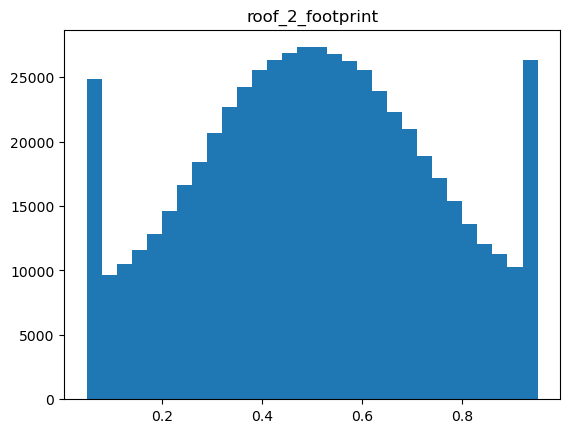

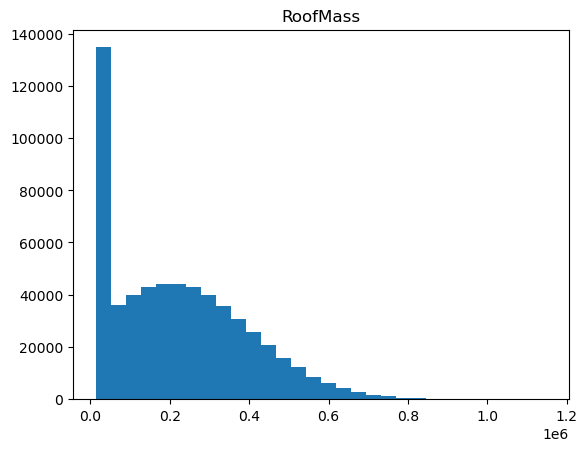

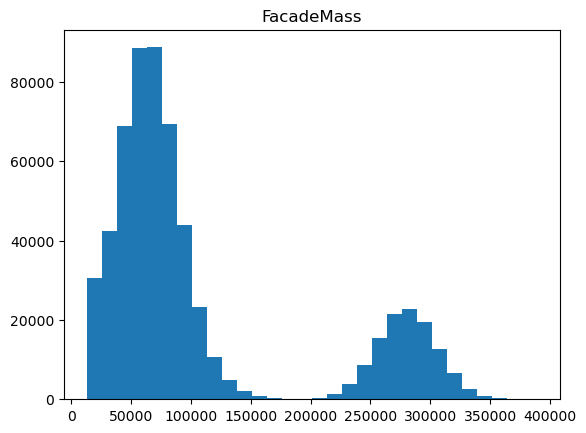

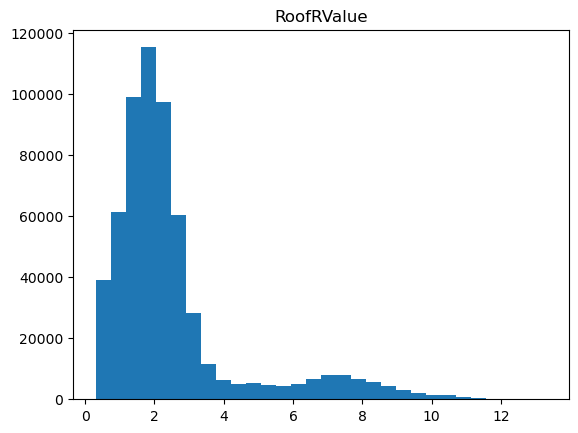

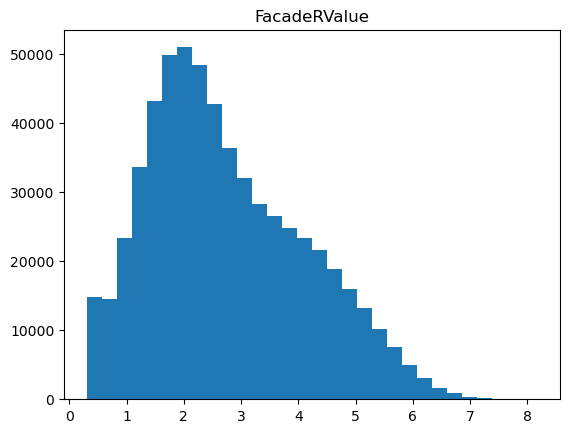

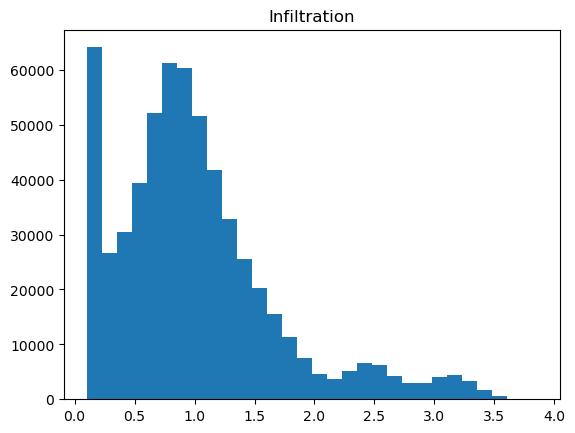

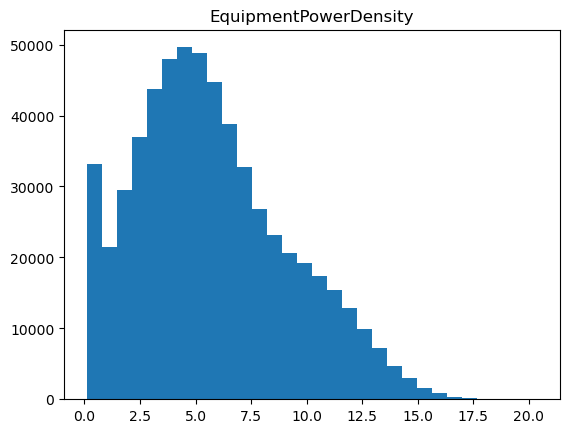

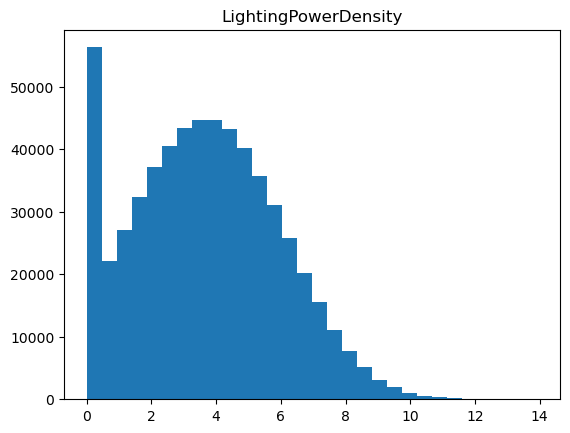

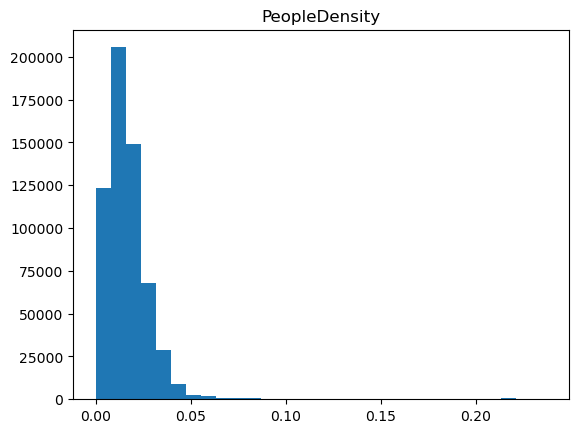

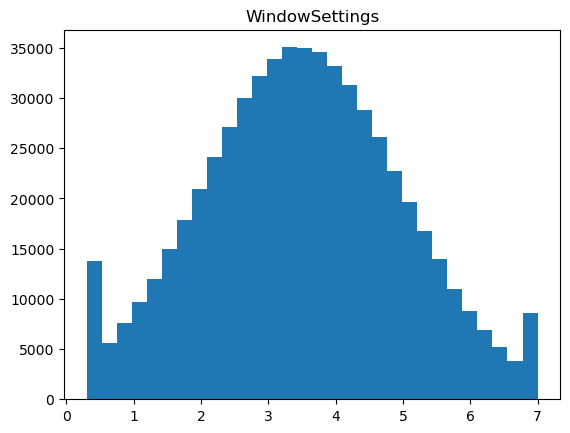

In [6]:
for param in ["roof_2_footprint","RoofMass", "FacadeMass", "RoofRValue", "FacadeRValue", "Infiltration", "EquipmentPowerDensity", "LightingPowerDensity", "PeopleDensity", "WindowSettings"]:
    plt.figure()
    vals = schema[param].extract_storage_values_batch(all_batches)
    plt.title(param)
    if param == "WindowSettings":
        vals = vals[:,0]
    hist = plt.hist(vals.flatten(), bins=30)